In [1]:
import os
import numpy as np
import reading 
from feature_extractor import feature_extractor
import pandas as pd
import matplotlib.pyplot as plt

Load dei Path, Con il sort giusto per far corrispondere i soggetti

In [2]:
paths_FA= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_FA_image")
paths_masks=reading.data_path("Diffusion_space_segmentations-20230215T134839Z-001","Diffusion_space_segmentations-20230215T134839Z-001")


#print((os.path.basename(paths_masks[0]).split('_')[2]))

paths_FA.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))
paths_masks.sort(key=lambda x: int(os.path.basename(x).split('_')[2]))


Feature extraction

In [3]:
region, mean, std=feature_extractor(paths_FA,paths_masks)


Reshape degli array per fare il Dataframe

In [4]:
mean_t=np.transpose(mean)
std_t=np.transpose(std)


Creo DataFrame per mean and std

In [5]:


df_mean = pd.DataFrame(mean_t[1:,1:177],index=mean[0][1:98],columns=region[1:177])
df_std=pd.DataFrame(std_t[1:,1:177],index=std[0][1:98],columns=region[1:177])

df_mean.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,wm-rh-superiorfrontal,wm-rh-superiorparietal,wm-rh-superiortemporal,wm-rh-supramarginal,wm-rh-frontalpole,wm-rh-temporalpole,wm-rh-transversetemporal,wm-rh-insula,Left-UnsegmentedWhiteMatter,Right-UnsegmentedWhiteMatter
1.0,0.008558,0.109013,0.172291,0.260344,0.122025,0.236524,0.126373,0.228594,0.230439,0.107770,...,0.252780,0.217847,0.258662,0.268637,0.276182,0.214232,0.158717,0.367259,0.301571,0.328116
2.0,0.010137,0.107341,0.171492,0.299163,0.133621,0.256451,0.160723,0.226560,0.239494,0.118588,...,0.286469,0.253083,0.261861,0.238354,0.260860,0.178386,0.178781,0.357016,0.330572,0.366950
3.0,0.008196,0.133892,0.112614,0.262373,0.111241,0.247089,0.133506,0.211761,0.219353,0.106775,...,0.254498,0.258600,0.268107,0.245099,0.270796,0.149528,0.172897,0.257598,0.295915,0.337266
4.0,0.012099,0.114534,0.134856,0.289858,0.112977,0.243535,0.153650,0.230634,0.249325,0.080339,...,0.256776,0.215121,0.285465,0.257601,0.238565,0.191491,0.177666,0.226578,0.301181,0.359059
5.0,0.011768,0.105971,0.110494,0.269097,0.106641,0.248220,0.139430,0.246313,0.263455,0.106332,...,0.232970,0.210857,0.304468,0.250227,0.257328,0.252974,0.189921,0.272185,0.309642,0.373039


Aggiungo i gruppi

In [6]:
a=pd.DataFrame(pd.read_csv('/home/francesco/CompProject/ADNI_dataset_diffusion.csv'))
a.sort_values(by=["Subject"],inplace=True)
group=a["Group"]
a.head()

,Subject,Group,Sex,Age
67,4002,0,F,74.0
68,4003,0,F,72.0
28,4009,1,M,90.0
69,4018,0,M,76.0
70,4050,0,M,77.0


Albero decisionale: creo i set e splitto

In [15]:
from sklearn import tree
from sklearn.model_selection import train_test_split


X=df_mean.values
y=group.values

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=.2, random_state=6)



Fitto l'albero

In [16]:

clf = tree.DecisionTreeClassifier()

y_score = clf.fit(X_tr, y_tr).predict_proba(X_tst)[:,1]

#tree.plot_tree(clf)
print(y_score)


[0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.]


In [17]:
import sklearn.metrics 
print(sklearn.metrics.roc_auc_score(y_tst, y_score))
fpr,tpr,thre = sklearn.metrics.roc_curve(y_tst, y_score)

0.5934065934065934


PLotto l'albero decisionale

In [18]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
#graph.render("iris") 

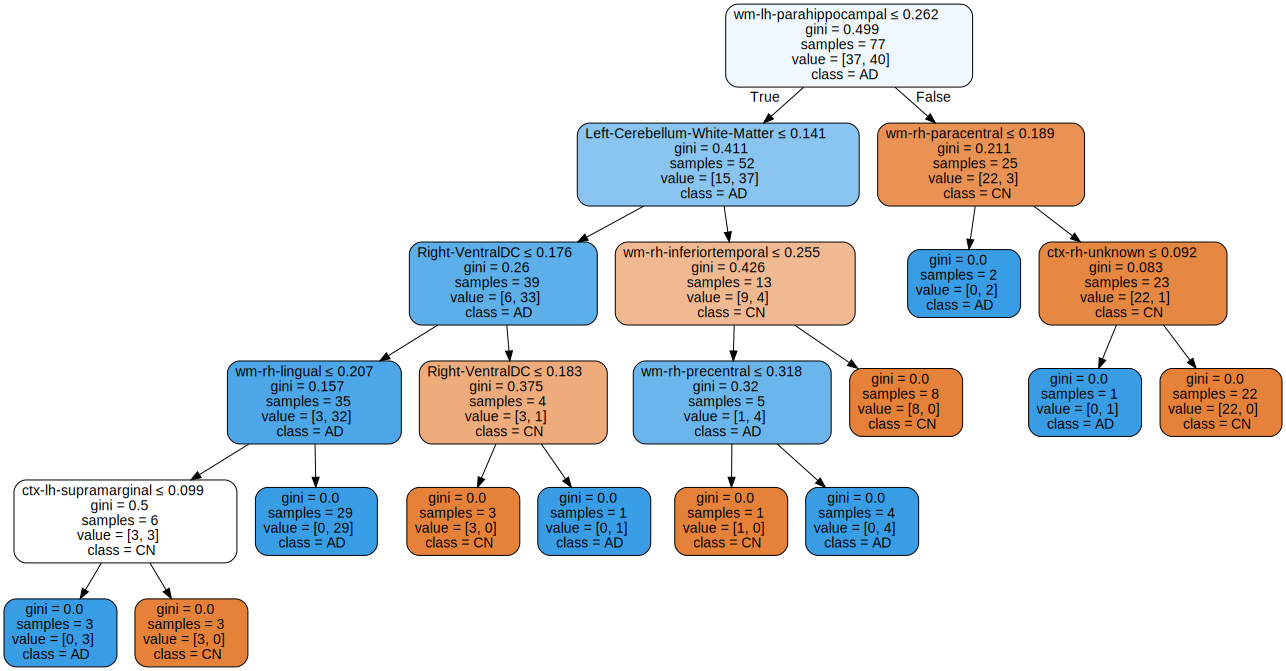

In [19]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=region[1:],  class_names=["CN","AD"],  filled=True, rounded=True,  special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Plotto la ROC

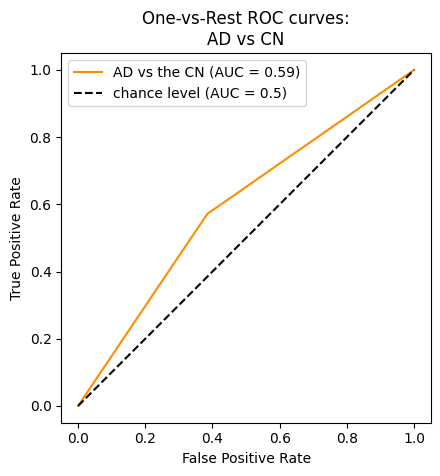

In [20]:

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_tst,y_score,name=f"AD vs the CN",color="darkorange",)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nAD vs CN")
plt.legend()
plt.show()

